In [1]:
# Component Testing Notebook for CBF-CLF Framework
# This notebook provides interactive tests to understand each component

import sys
import os
sys.path.append(os.path.abspath('..'))

In [8]:
# Import all necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import framework components
from src.cbf import EnsembleCBF, CBFNetwork
from src.clf import EnsembleCLF, CLFNetwork
from src.models import EnsembleDynamics, ReplayBuffer
from src.core.policy import SubgoalConditionedPolicy
from src.planning.fsm_planner import FSMState, FSMTransition, FSMAutomaton
from src.environment import WarehouseEnvironment
from src.dataset import create_warehouse_dataset

# Import visualization utilities
from src.visualization import EnvironmentVisualizer, FunctionVisualizer, plot_side_by_side

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ All imports successful!
PyTorch version: 2.8.0
Device: cpu


TEST 1: Warehouse Environment - Understanding the World

🏭 Warehouse Specifications:
  - Workspace size: 12.0m × 10.0m
  - Number of obstacles: 11
  - Number of goal regions: 4

🔴 Obstacle Details:
  Obstacle 0: center=[2. 3.], radius=0.8m
  Obstacle 1: center=[2. 7.], radius=0.8m
  Obstacle 2: center=[5. 2.], radius=0.6m
  Obstacle 3: center=[5. 5.], radius=0.6m
  Obstacle 4: center=[5. 8.], radius=0.6m
  ... and 6 more obstacles

🎯 Goal Region Details:
  Goal 0: center=[10.5  8.5], radius=0.4m
  Goal 1: center=[10.5  1.5], radius=0.4m
  Goal 2: center=[1.5 9. ], radius=0.3m
  Goal 3: center=[6.5 0.5], radius=0.3m

⚙️  Understanding Physics:
  Physics uses Forward Euler integration with dt=0.1s
  Formula: new_vel = old_vel + action * 0.1
  Formula: new_pos = old_pos + new_vel * 0.1
  This means: Δpos ≈ action * 0.01 per step

  Initial state [x, y, vx, vy]: [0.5 0.2 0.  0. ]

📍 Simulating Extended Robot Motion (20 steps):

  Applying constant action [3. 2.] for 20 steps...

  Step 1:


/Users/matthewtaruno/Dev/long-horizon/src/visualization.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(
/Users/matthewtaruno/Dev/long-horizon/src/visualization.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(


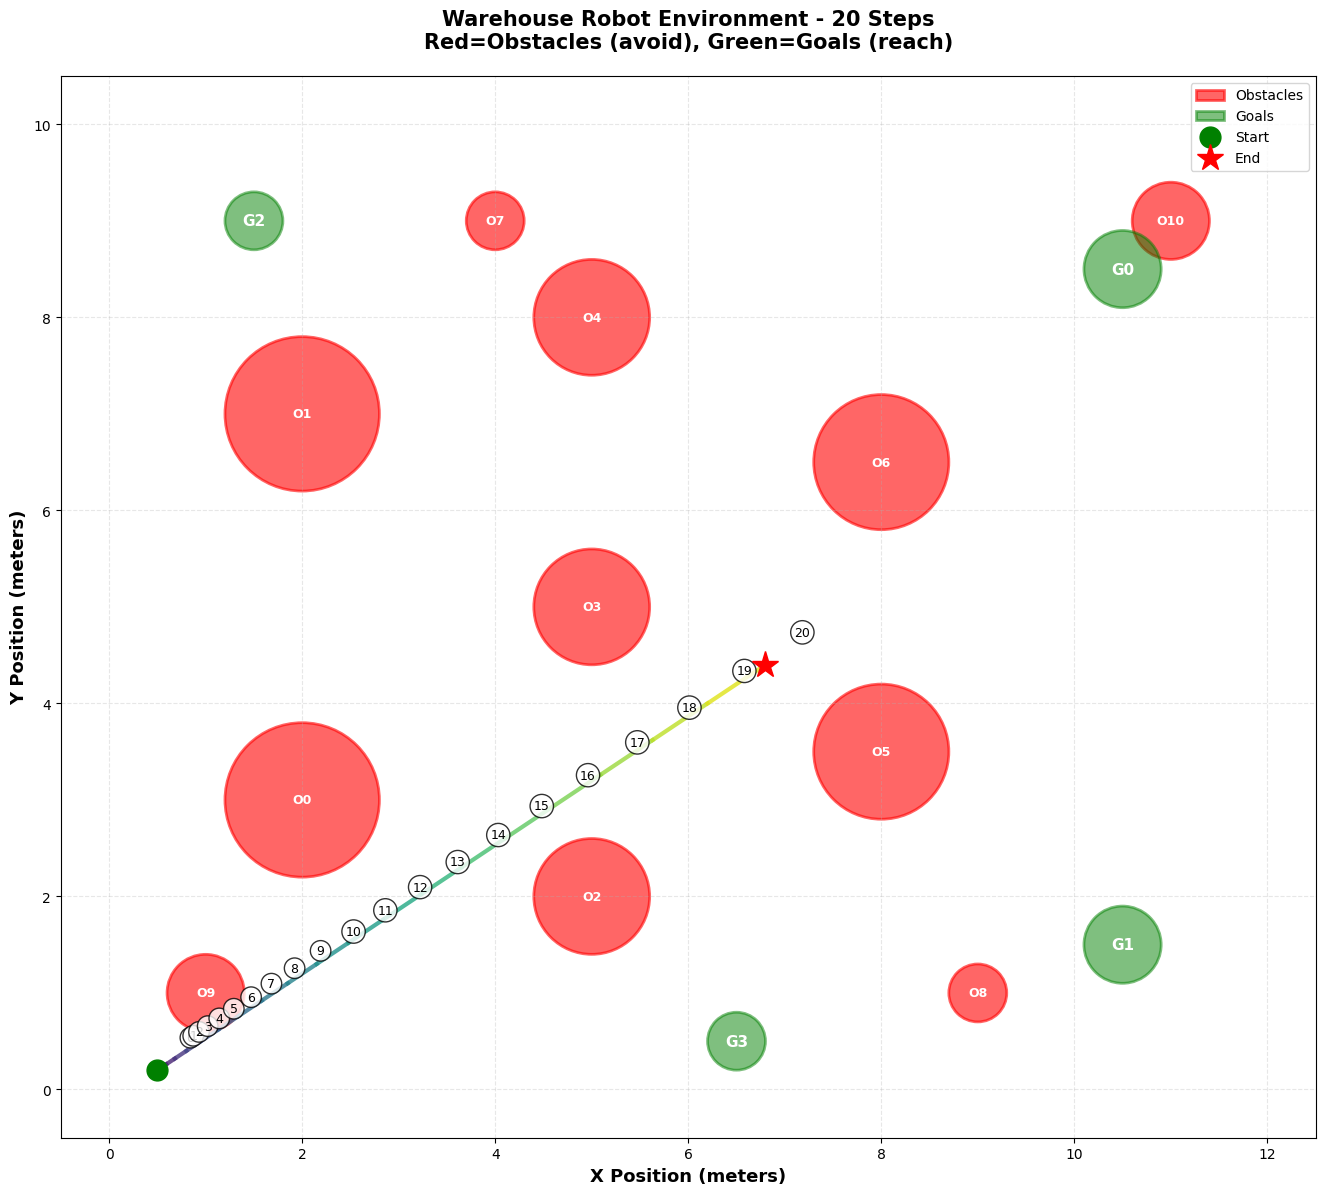


KEY INSIGHTS:
• State: [x, y, vx, vy] - position (2D) and velocity (2D)
• Action: [ax, ay] - acceleration commands (2D)
• Physics (Forward Euler Integration with dt=0.1s):
    new_vel = old_vel + action * dt     → velocity changes slowly
    new_pos = old_pos + new_vel * dt    → position integrates velocity
• Double time scaling means:
    Δpos_per_step ≈ action * 0.01     → VERY small movement per step!
    This is why we need 20+ steps to see visible movement
• Reward Structure:
    - Base: -distance to nearest goal (encourages approach)
    - Penalty: -10 for collision
    - Bonus: +50 for reaching goal
• The robot builds up velocity over time (momentum-based physics)

✅ Environment test complete! Now you understand:
   1. The robot has INERTIA - it doesn't teleport, it accelerates
   2. Movement is gradual due to dt=0.1 scaling
   3. This makes the problem realistic but requires planning!


In [10]:
# ============================================================================
# TEST 1: Warehouse Environment - Understanding the World
# ============================================================================

print("=" * 70)
print("TEST 1: Warehouse Environment - Understanding the World")
print("=" * 70)

# Create the warehouse environment
env = WarehouseEnvironment()

# Display environment specifications
print(f"\n🏭 Warehouse Specifications:")
print(f"  - Workspace size: {env.bounds[0]}m × {env.bounds[1]}m")
print(f"  - Number of obstacles: {len(env.obstacles)}")
print(f"  - Number of goal regions: {len(env.goals)}")

print(f"\n🔴 Obstacle Details:")
for i, obs in enumerate(env.obstacles[:5]):  # Show first 5
    print(f"  Obstacle {i}: center={obs['center']}, radius={obs['radius']}m")
if len(env.obstacles) > 5:
    print(f"  ... and {len(env.obstacles) - 5} more obstacles")

print(f"\n🎯 Goal Region Details:")
for i, goal in enumerate(env.goals):
    print(f"  Goal {i}: center={goal['center']}, radius={goal['radius']}m")

# Test the environment dynamics
print(f"\n⚙️  Understanding Physics:")
print(f"  Physics uses Forward Euler integration with dt=0.1s")
print(f"  Formula: new_vel = old_vel + action * 0.1")
print(f"  Formula: new_pos = old_pos + new_vel * 0.1")
print(f"  This means: Δpos ≈ action * 0.01 per step")

initial_state = env.reset()
print(f"\n  Initial state [x, y, vx, vy]: {initial_state}")

# Simulate MANY steps to see meaningful movement
print(f"\n📍 Simulating Extended Robot Motion (20 steps):")

# Store trajectory
trajectory_states = [initial_state.copy()]

# Create a consistent action to move right and up toward goal
action = np.array([3.0, 2.0])  # Strong, consistent acceleration

total_steps = 20
print(f"\n  Applying constant action {action} for {total_steps} steps...")

for step in range(total_steps):
    next_state, reward, done, sensors = env.step(action)
    trajectory_states.append(next_state.copy())
    
    # Show some intermediate results
    if step in [0, 4, 9, 14, 19]:
        print(f"\n  Step {step+1}:")
        print(f"    Position: ({next_state[0]:.4f}, {next_state[1]:.4f})")
        print(f"    Velocity: ({next_state[2]:.4f}, {next_state[3]:.4f})")
        print(f"    Reward: {reward:.2f}")
        print(f"    Collision: {sensors['collision']}")
        if sensors['collision']:
            print(f"    💥 COLLISION DETECTED! Episode terminated.")
            break

# Calculate total distance traveled
start_pos = trajectory_states[0][:2]
end_pos = trajectory_states[-1][:2]
distance = np.linalg.norm(end_pos - start_pos)

print(f"\nMotion Summary:")
print(f"  Start position: {start_pos}")
print(f"  End position: {end_pos}")
print(f"  Total distance traveled: {distance:.3f}m")
print(f"  Number of steps: {len(trajectory_states)-1}")

# Visualize using clean visualization module
print(f"\nCreating visualization...")

viz = EnvironmentVisualizer(env)
fig, ax = viz.plot_trajectory_sequence(
    trajectory_states,
    title=f"Warehouse Robot Environment - {len(trajectory_states)-1} Steps\nRed=Obstacles (avoid), Green=Goals (reach)"
)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("• State: [x, y, vx, vy] - position (2D) and velocity (2D)")
print("• Action: [ax, ay] - acceleration commands (2D)")
print("• Physics (Forward Euler Integration with dt=0.1s):")
print("    new_vel = old_vel + action * dt     → velocity changes slowly")
print("    new_pos = old_pos + new_vel * dt    → position integrates velocity")
print("• Double time scaling means:")
print("    Δpos_per_step ≈ action * 0.01     → VERY small movement per step!")
print("    This is why we need 20+ steps to see visible movement")
print("• Reward Structure:")
print("    - Base: -distance to nearest goal (encourages approach)")
print("    - Penalty: -10 for collision")
print("    - Bonus: +50 for reaching goal")
print("• The robot builds up velocity over time (momentum-based physics)")
print("="*70)
print("\n✅ Environment test complete! Now you understand:")
print("   1. The robot has INERTIA - it doesn't teleport, it accelerates")
print("   2. Movement is gradual due to dt=0.1 scaling")
print("   3. This makes the problem realistic but requires planning!")

TEST 2: Dataset Generation

 Dataset Statistics:
  - Total transitions: 200
  - Safe states: 172 (86.0%)
  - Unsafe states: 28 (14.0%)
  - Goal states: 0 (0.0%)

 Sample Transitions:

Transition 1:
  State: pos=(6.62, 6.17), vel=(0.26, 0.40)
  Action: [-0.21921186 -0.81401498]
  Next State: pos=(6.64, 6.20), vel=(0.24, 0.32)
  Reward: -4.49
  Safe: True, Goal: False

Transition 2:
  State: pos=(9.35, 6.28), vel=(0.14, 0.50)
  Action: [-0.74831801 -0.51515854]
  Next State: pos=(9.36, 6.33), vel=(0.07, 0.44)
  Reward: -2.45
  Safe: True, Goal: False

Transition 3:
  State: pos=(9.83, 3.76), vel=(-0.32, 0.33)
  Action: [-0.84528048  0.18274542]
  Next State: pos=(9.79, 3.79), vel=(-0.40, 0.34)
  Reward: -4.76
  Safe: True, Goal: False

 Creating dataset visualization...


/var/folders/ng/qxf69y2d3fv6c8v85r6g6hgc0000gn/T/ipykernel_478/1804122619.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'], color='red', alpha=0.3, edgecolor='darkred', linewidth=2)
/var/folders/ng/qxf69y2d3fv6c8v85r6g6hgc0000gn/T/ipykernel_478/1804122619.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(goal['center'], goal['radius'], color='green', alpha=0.2, edgecolor='darkgreen', linewidth=2)


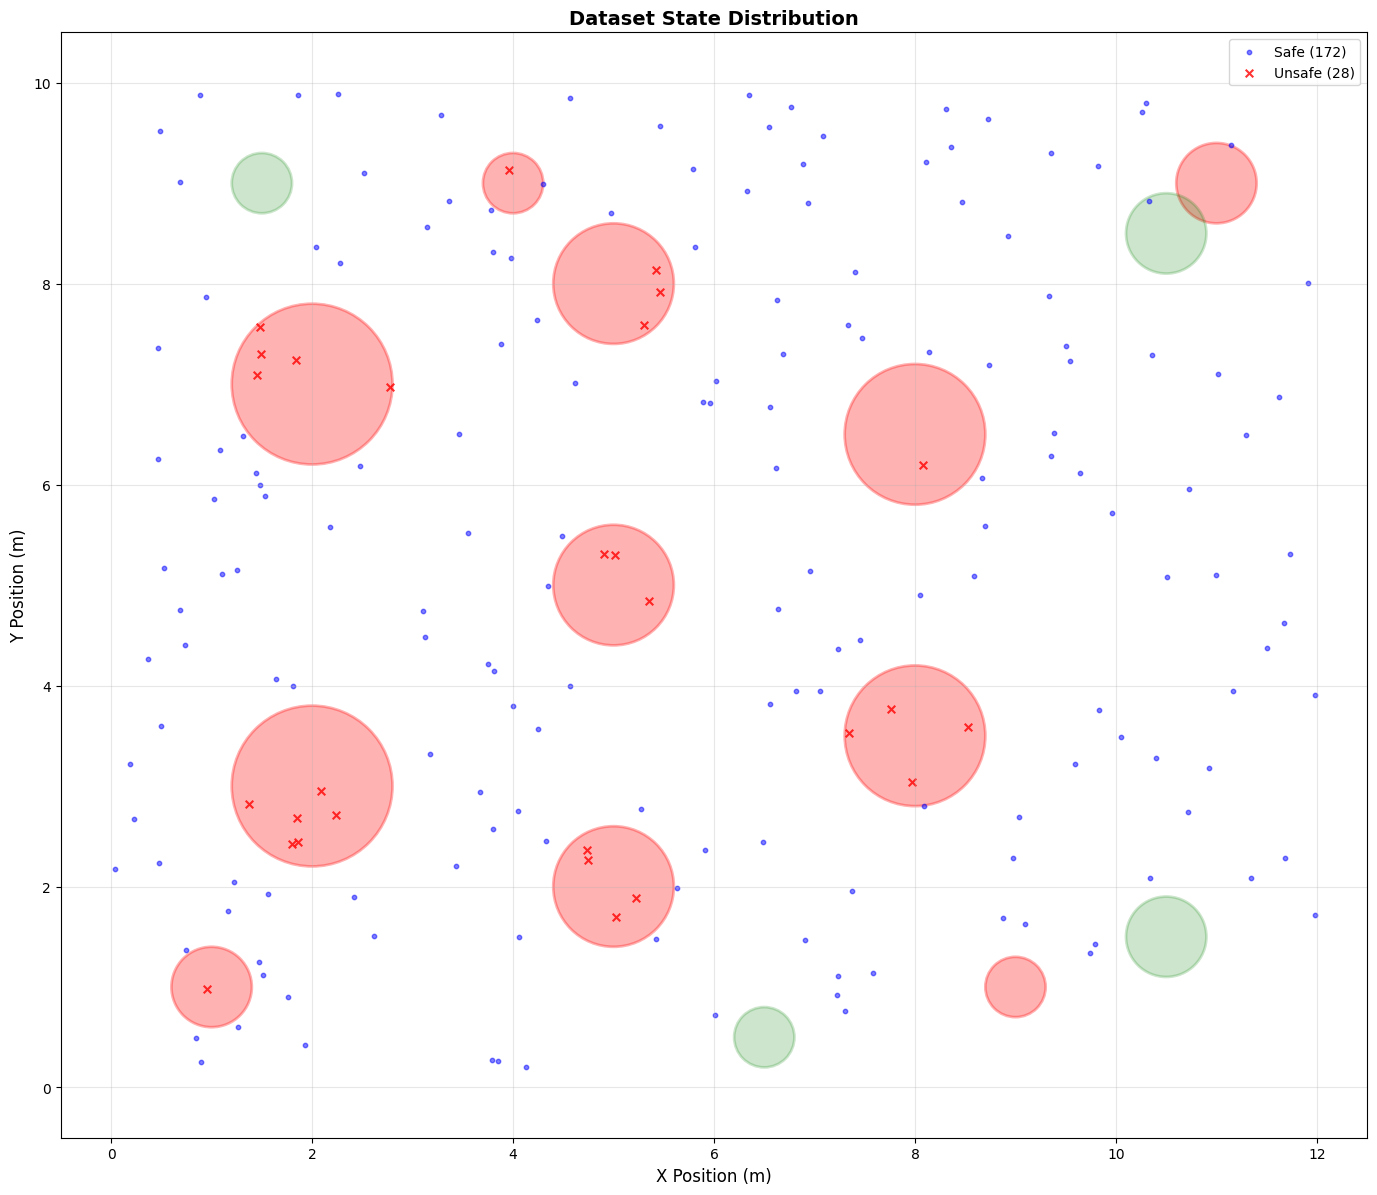


KEY INSIGHTS:
• Dataset now uses SAME layout as WarehouseEnvironment
• Safe states (blue dots): Should be OUTSIDE obstacles
• Unsafe states (red X): Should be INSIDE obstacles
• Goal states (gold stars): Should be in green goal regions
• Random sampling creates more safe than unsafe states naturally
• This labeled data will train CBF (safety) and CLF (goal-seeking)

✅ Dataset test complete!


In [16]:
# ============================================================================
# TEST 2: Dataset - Understanding Training Data
# ============================================================================
print("=" * 70)
print("TEST 2: Dataset Generation")
print("=" * 70)

# Generate small dataset (now matches environment!)
transitions = create_warehouse_dataset(num_transitions=200)

# Analyze dataset
safe_count = sum(1 for t in transitions if t.is_safe)
unsafe_count = sum(1 for t in transitions if not t.is_safe)
goal_count = sum(1 for t in transitions if t.is_goal)

print(f"\n Dataset Statistics:")
print(f"  - Total transitions: {len(transitions)}")
print(f"  - Safe states: {safe_count} ({safe_count/len(transitions)*100:.1f}%)")
print(f"  - Unsafe states: {unsafe_count} ({unsafe_count/len(transitions)*100:.1f}%)")
print(f"  - Goal states: {goal_count} ({goal_count/len(transitions)*100:.1f}%)")

# Show sample transitions
print(f"\n Sample Transitions:")
for i, t in enumerate(transitions[:3]):
    print(f"\nTransition {i+1}:")
    print(f"  State: pos=({t.state[0]:.2f}, {t.state[1]:.2f}), vel=({t.state[2]:.2f}, {t.state[3]:.2f})")
    print(f"  Action: {t.action}")
    print(f"  Next State: pos=({t.next_state[0]:.2f}, {t.next_state[1]:.2f}), vel=({t.next_state[2]:.2f}, {t.next_state[3]:.2f})")
    print(f"  Reward: {t.reward:.2f}")
    print(f"  Safe: {t.is_safe}, Goal: {t.is_goal}")

# Visualize dataset with environment overlay
print(f"\n Creating dataset visualization...")

fig, ax = plt.subplots(figsize=(14, 12))
ax.set_xlim(-0.5, env.bounds[0] + 0.5)
ax.set_ylim(-0.5, env.bounds[1] + 0.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Draw environment (should now match dataset!)
for obs in env.obstacles:
    circle = patches.Circle(obs['center'], obs['radius'], color='red', alpha=0.3, edgecolor='darkred', linewidth=2)
    ax.add_patch(circle)

for goal in env.goals:
    circle = patches.Circle(goal['center'], goal['radius'], color='green', alpha=0.2, edgecolor='darkgreen', linewidth=2)
    ax.add_patch(circle)

# Plot states with correct labels
safe_positions = [t.state[:2] for t in transitions if t.is_safe and not t.is_goal]
unsafe_positions = [t.state[:2] for t in transitions if not t.is_safe]
goal_positions = [t.state[:2] for t in transitions if t.is_goal]

if safe_positions:
    safe_array = np.array(safe_positions)
    ax.scatter(safe_array[:, 0], safe_array[:, 1], c='blue', s=10, alpha=0.5, label=f'Safe ({len(safe_positions)})')

if unsafe_positions:
    unsafe_array = np.array(unsafe_positions)
    ax.scatter(unsafe_array[:, 0], unsafe_array[:, 1], c='red', s=30, marker='x', alpha=0.8, label=f'Unsafe ({len(unsafe_positions)})')

if goal_positions:
    goal_array = np.array(goal_positions)
    ax.scatter(goal_array[:, 0], goal_array[:, 1], c='gold', s=50, marker='*', alpha=0.9, label=f'Goal ({len(goal_positions)})')

ax.set_xlabel('X Position (m)', fontsize=12)
ax.set_ylabel('Y Position (m)', fontsize=12)
ax.set_title('Dataset State Distribution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("• Dataset now uses SAME layout as WarehouseEnvironment")
print("• Safe states (blue dots): Should be OUTSIDE obstacles")
print("• Unsafe states (red X): Should be INSIDE obstacles")
print("• Goal states (gold stars): Should be in green goal regions")
print("• Random sampling creates more safe than unsafe states naturally")
print("• This labeled data will train CBF (safety) and CLF (goal-seeking)")
print("="*70)
print("\n✅ Dataset test complete!")

TEST 3: Control Barrier Function (Safety)

🛡️  CBF Network Architecture:
  - Input dimension: 4 (x, y, vx, vy)
  - Hidden layers: (64, 64)
  - Output: h(s) ∈ ℝ (scalar safety value)
  - Parameters: 4,801

📊 CBF Values (before training):
  State 1 [1. 1.]: h(s) = -0.6049
  State 2 [2. 3.]: h(s) = -0.3870
  State 3 [10.5  8.5]: h(s) = -0.2860

🏋️  Training CBF on dataset...
  - Safe training states: 174
  - Unsafe training states: 26


/var/folders/ng/qxf69y2d3fv6c8v85r6g6hgc0000gn/T/ipykernel_478/1435078434.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  safe_states = torch.FloatTensor([t.state for t in transitions if t.is_safe])


  Epoch 0: Loss = 0.0978
  Epoch 20: Loss = 0.0071
  Epoch 40: Loss = 0.0006
  Epoch 60: Loss = 0.0001
  Epoch 80: Loss = 0.0001

📊 CBF Values (after training):
  State 1 [1. 1.]: h(s) = +0.0537 ✓ SAFE
  State 2 [2. 3.]: h(s) = +0.0236 ✓ SAFE
  State 3 [10.5  8.5]: h(s) = -0.0006 ✗ UNSAFE

📊 Creating visualizations...


/Users/matthewtaruno/Dev/long-horizon/src/visualization.py:238: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle(obs['center'], obs['radius'],


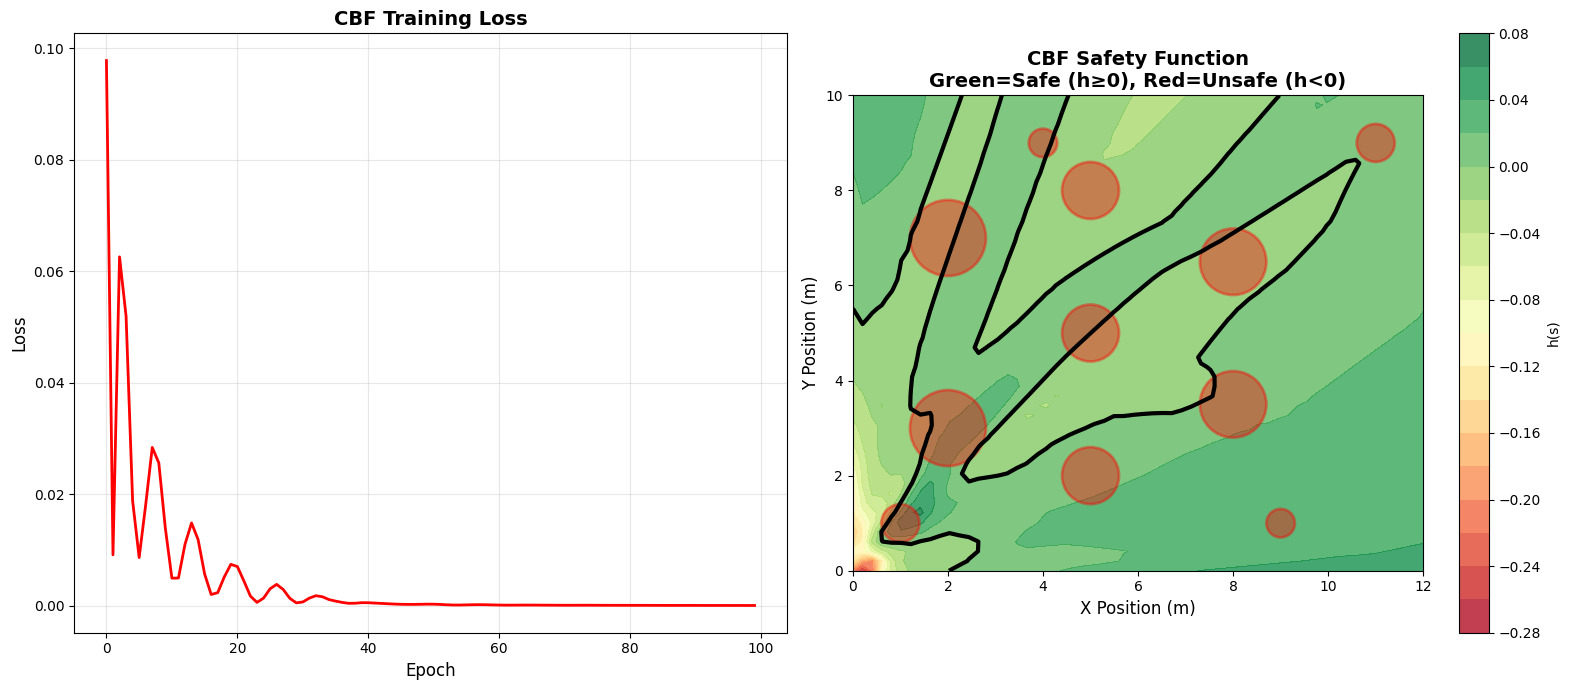


KEY INSIGHTS:
• CBF learns to classify: h(s) ≥ 0 for safe, h(s) < 0 for unsafe
• Black boundary line shows h(s) = 0 (safety boundary)
• Green regions: robot can operate safely
• Red regions: collision risk (near obstacles)
• This provides a differentiable safety certificate!

✅ CBF test complete!


In [ ]:
# ============================================================================
# TEST 3: CBF (Control Barrier Function) - Learning Safety
# ============================================================================

print("=" * 70)
print("TEST 3: Control Barrier Function (Safety)")
print("=" * 70)

# Create CBF network
cbf = CBFNetwork(state_dim=4, hidden_dims=(64, 64), device='cpu')

print(f"\n🛡️  CBF Network Architecture:")
print(f"  - Input dimension: 4 (x, y, vx, vy)")
print(f"  - Hidden layers: (64, 64)")
print(f"  - Output: h(s) ∈ ℝ (scalar safety value)")
print(f"  - Parameters: {sum(p.numel() for p in cbf.parameters()):,}")

# Test CBF on sample states
test_states = torch.FloatTensor([
    [1.0, 1.0, 0.0, 0.0],   # Safe position
    [2.0, 3.0, 0.0, 0.0],   # Near obstacle center
    [10.5, 8.5, 0.0, 0.0],  # Near goal
])

print(f"\n📊 CBF Values (before training):")
with torch.no_grad():
    h_values = cbf(test_states).squeeze()
    for i, h in enumerate(h_values):
        state = test_states[i]
        print(f"  State {i+1} {state[:2].numpy()}: h(s) = {h.item():.4f}")

# Train CBF on dataset
print(f"\n🏋️  Training CBF on dataset...")

safe_states = torch.FloatTensor([t.state for t in transitions if t.is_safe])
unsafe_states = torch.FloatTensor([t.state for t in transitions if not t.is_safe])

print(f" - Safe training states: {len(safe_states)}")
print(f" - Unsafe training states: {len(unsafe_states)}")

optimizer = torch.optim.Adam(cbf.parameters(), lr=1e-3)

losses = []
for epoch in range(100):
    optimizer.zero_grad() # Reset gradients
    
    # Safe states should have h(s) ≥ 0
    h_safe = cbf(safe_states).squeeze()
    loss_safe = torch.mean(torch.clamp(-h_safe, min=0.0) ** 2)
    
    # Unsafe states should have h(s) < 0
    h_unsafe = cbf(unsafe_states).squeeze()
    loss_unsafe = torch.mean(torch.clamp(h_unsafe, min=0.0) ** 2)
    
    loss = loss_safe + loss_unsafe
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"  Epoch {epoch}: Loss = {loss.item():.4f}")

# Test again after training
print(f"\n📊 CBF Values (after training):")
with torch.no_grad():
    h_values = cbf(test_states).squeeze()
    for i, h in enumerate(h_values):
        state = test_states[i]
        safe_label = "✓ SAFE" if h.item() >= 0 else "✗ UNSAFE"
        print(f"  State {i+1} {state[:2].numpy()}: h(s) = {h.item():+.4f} {safe_label}")

# Visualize using clean visualization module
print(f"\n📊 Creating visualizations...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Training loss
func_viz = FunctionVisualizer(env)
func_viz.plot_training_curves(losses, title='CBF Training Loss', ax=ax1, color='red')

# Plot 2: CBF heatmap
func_viz.plot_cbf_heatmap(cbf, ax=ax2)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("• CBF learns to classify: h(s) ≥ 0 for safe, h(s) < 0 for unsafe")
print("• Black boundary line shows h(s) = 0 (safety boundary)")
print("• Green regions: robot can operate safely")
print("• Red regions: collision risk (near obstacles)")
print("• This provides a differentiable safety certificate!")
print("="*70)


TEST 4: Control Lyapunov Function (Feasibility)

🎯 CLF Network Architecture:
  - Input dimension: 4 (x, y, vx, vy)
  - Hidden layers: (64, 64)
  - Output: V(s) ∈ ℝ≥0 (goal distance, non-negative)
  - Parameters: 4,801

📊 CLF Values (before training):
  State 1 at [10.5  8.5]: V(s) = 1.0528, actual distance = 0.00m
  State 2 at [9.5 8.5]: V(s) = 1.0526, actual distance = 1.00m
  State 3 at [8.5 8.5]: V(s) = 1.0452, actual distance = 2.00m
  State 4 at [5. 5.]: V(s) = 1.0987, actual distance = 6.52m

🏋️  Training CLF on dataset...
  - Goal training states: 0
  - Non-goal states for positivity constraint: 200

⚠️  WARNING: No goal states found in dataset!
   Regenerating dataset with more transitions to ensure goal coverage...
   After regeneration: 14 goal states found
  Epoch 0: Loss = 0.9706 (goal_loss=0.9706, pos_loss=0.0000)
  Epoch 20: Loss = 0.0042 (goal_loss=0.0040, pos_loss=0.0018)
  Epoch 40: Loss = 0.0022 (goal_loss=0.0019, pos_loss=0.0035)
  Epoch 60: Loss = 0.0018 (goal_loss=

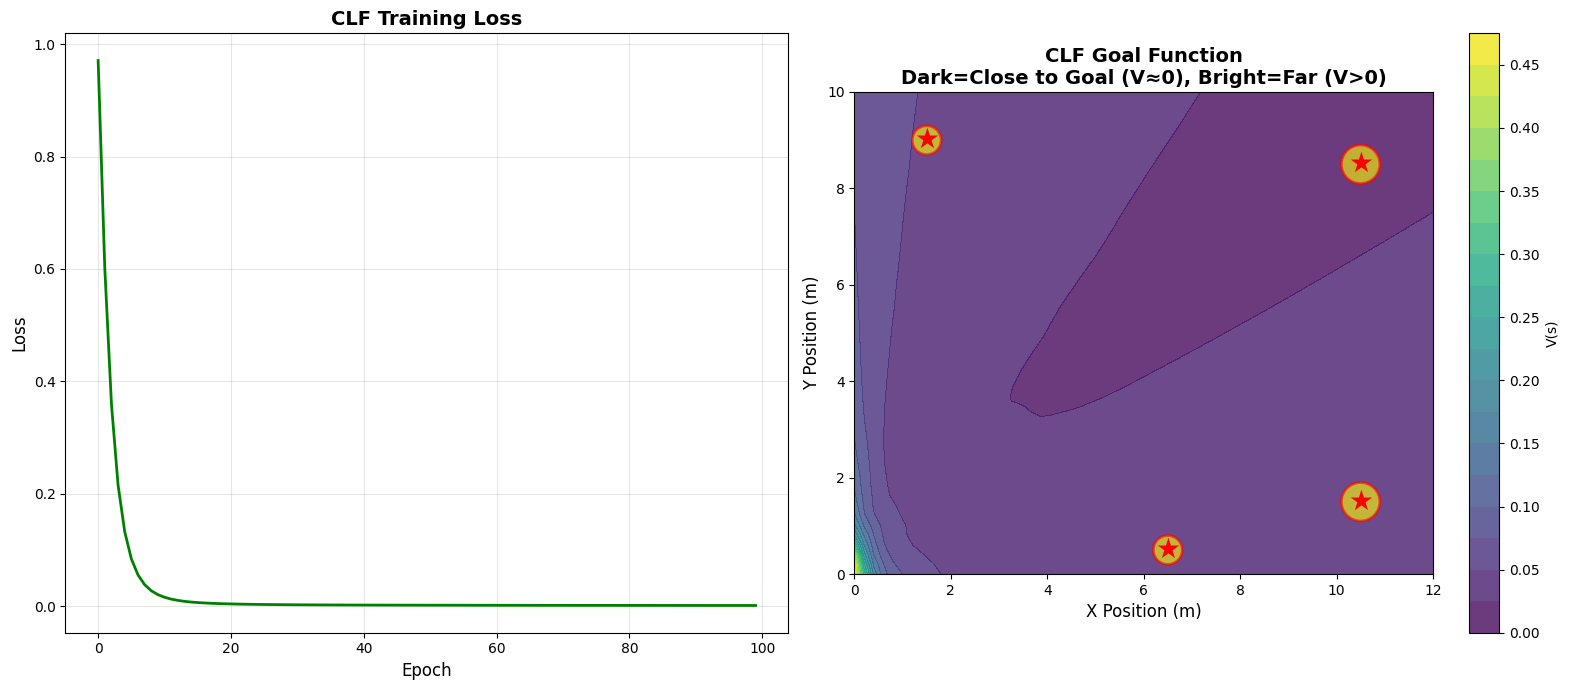


KEY INSIGHTS:
• CLF learns goal distance: V(goal) ≈ 0, V(s) > 0 elsewhere
• Dark regions: close to goal (low V)
• Bright regions: far from goal (high V)
• Yellow stars mark goal regions
• This provides a differentiable goal-seeking function!
• V(s) should decrease along trajectories toward goals

✅ CLF test complete!


In [20]:
# ============================================================================
# TEST 4: CLF (Control Lyapunov Function) - Learning Goal Convergence
# ============================================================================

print("=" * 70)
print("TEST 4: Control Lyapunov Function (Feasibility)")
print("=" * 70)

# Create CLF network
clf = CLFNetwork(state_dim=4, hidden_dims=(64, 64), device='cpu')

print(f"\n🎯 CLF Network Architecture:")
print(f"  - Input dimension: 4 (x, y, vx, vy)")
print(f"  - Hidden layers: (64, 64)")
print(f"  - Output: V(s) ∈ ℝ≥0 (goal distance, non-negative)")
print(f"  - Parameters: {sum(p.numel() for p in clf.parameters()):,}")

# Test CLF on sample states at various distances from goal
goal_pos = np.array([10.5, 8.5])  # Goal location
test_states_clf = torch.FloatTensor([
    [10.5, 8.5, 0.0, 0.0],  # At goal
    [9.5, 8.5, 0.0, 0.0],   # 1m from goal
    [8.5, 8.5, 0.0, 0.0],   # 2m from goal
    [5.0, 5.0, 0.0, 0.0],   # Far from goal
])

distances = [np.linalg.norm(s[:2] - goal_pos) for s in test_states_clf.numpy()]

print(f"\n📊 CLF Values (before training):")
with torch.no_grad():
    V_values = clf(test_states_clf).squeeze()
    for i, V in enumerate(V_values):
        state = test_states_clf[i]
        print(f"  State {i+1} at {state[:2].numpy()}: V(s) = {V.item():.4f}, actual distance = {distances[i]:.2f}m")

# Train CLF on dataset - FIXED: Use states that are in goal regions
print(f"\n🏋️  Training CLF on dataset...")

# Filter for goal states - states where is_goal is True
goal_states = torch.FloatTensor([t.state for t in transitions if t.is_goal])
non_goal_states = torch.FloatTensor([t.state for t in transitions if not t.is_goal])

print(f"  - Goal training states: {len(goal_states)}")
print(f"  - Non-goal states for positivity constraint: {len(non_goal_states)}")

if len(goal_states) == 0:
    print("\n⚠️  WARNING: No goal states found in dataset!")
    print("   Regenerating dataset with more transitions to ensure goal coverage...")
    transitions = create_warehouse_dataset(num_transitions=1000)
    goal_states = torch.FloatTensor([t.state for t in transitions if t.is_goal])
    non_goal_states = torch.FloatTensor([t.state for t in transitions if not t.is_goal])
    print(f"   After regeneration: {len(goal_states)} goal states found")

optimizer_clf = torch.optim.Adam(clf.parameters(), lr=1e-3)

clf_losses = []
for epoch in range(100):
    optimizer_clf.zero_grad()
    
    # Goal states should have V(s) = 0
    if len(goal_states) > 0:
        V_goal = clf(goal_states).squeeze()
        loss_goal = torch.mean(V_goal ** 2)
    else:
        loss_goal = torch.tensor(0.0)
    
    # Ensure V(s) > 0 for non-goal states (with small margin)
    V_non_goal = clf(non_goal_states).squeeze()
    loss_positive = torch.mean(torch.clamp(0.1 - V_non_goal, min=0.0) ** 2)
    
    loss = loss_goal + 0.1 * loss_positive
    loss.backward()
    optimizer_clf.step()
    
    clf_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"  Epoch {epoch}: Loss = {loss.item():.4f} (goal_loss={loss_goal.item():.4f}, pos_loss={loss_positive.item():.4f})")

# Test again after training
print(f"\n📊 CLF Values (after training):")
with torch.no_grad():
    V_values = clf(test_states_clf).squeeze()
    for i, V in enumerate(V_values):
        state = test_states_clf[i]
        status = "✓ AT GOAL" if V.item() < 0.1 else f"→ {distances[i]:.2f}m to goal"
        print(f"  State {i+1} at {state[:2].numpy()}: V(s) = {V.item():.4f} {status}")

# Visualize using clean visualization module
print(f"\n📊 Creating visualizations...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Training loss
func_viz = FunctionVisualizer(env)
func_viz.plot_training_curves(clf_losses, title='CLF Training Loss', ax=ax1, color='green')

# Plot 2: CLF heatmap
func_viz.plot_clf_heatmap(clf, ax=ax2)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("• CLF learns goal distance: V(goal) ≈ 0, V(s) > 0 elsewhere")
print("• Dark regions: close to goal (low V)")
print("• Bright regions: far from goal (high V)")
print("• Yellow stars mark goal regions")
print("• This provides a differentiable goal-seeking function!")
print("• V(s) should decrease along trajectories toward goals")
print("="*70)
print("\n✅ CLF test complete!")

TEST 5: Dynamics Model (Learning Environment Physics)

⚙️  Ensemble Dynamics Architecture:
  - Number of models: 3 (for uncertainty estimation)
  - Input: state (4D) + action (2D) = 6D
  - Hidden layers: (128, 128)
  - Output: next_state (4D)
  - Total parameters: 55,308

📊 Training Data:
  - Training samples: 200

🏋️  Training Dynamics Model...
  Epoch 0: MSE Loss = 0.077367
  Epoch 20: MSE Loss = 0.019302
  Epoch 40: MSE Loss = 0.012338
  Epoch 60: MSE Loss = 0.009610
  Epoch 80: MSE Loss = 0.008152

📊 Prediction Accuracy Test:
  Input State: [6.6155825  6.166217   0.25965482 0.40432507]
  Action: [-0.21921186 -0.814015  ]
  True Next State: [6.639356   6.198509   0.23773365 0.32292357]
  Predicted Next: [6.5922217  6.20739    0.23709296 0.42132583]
  Position Error: 0.047964m


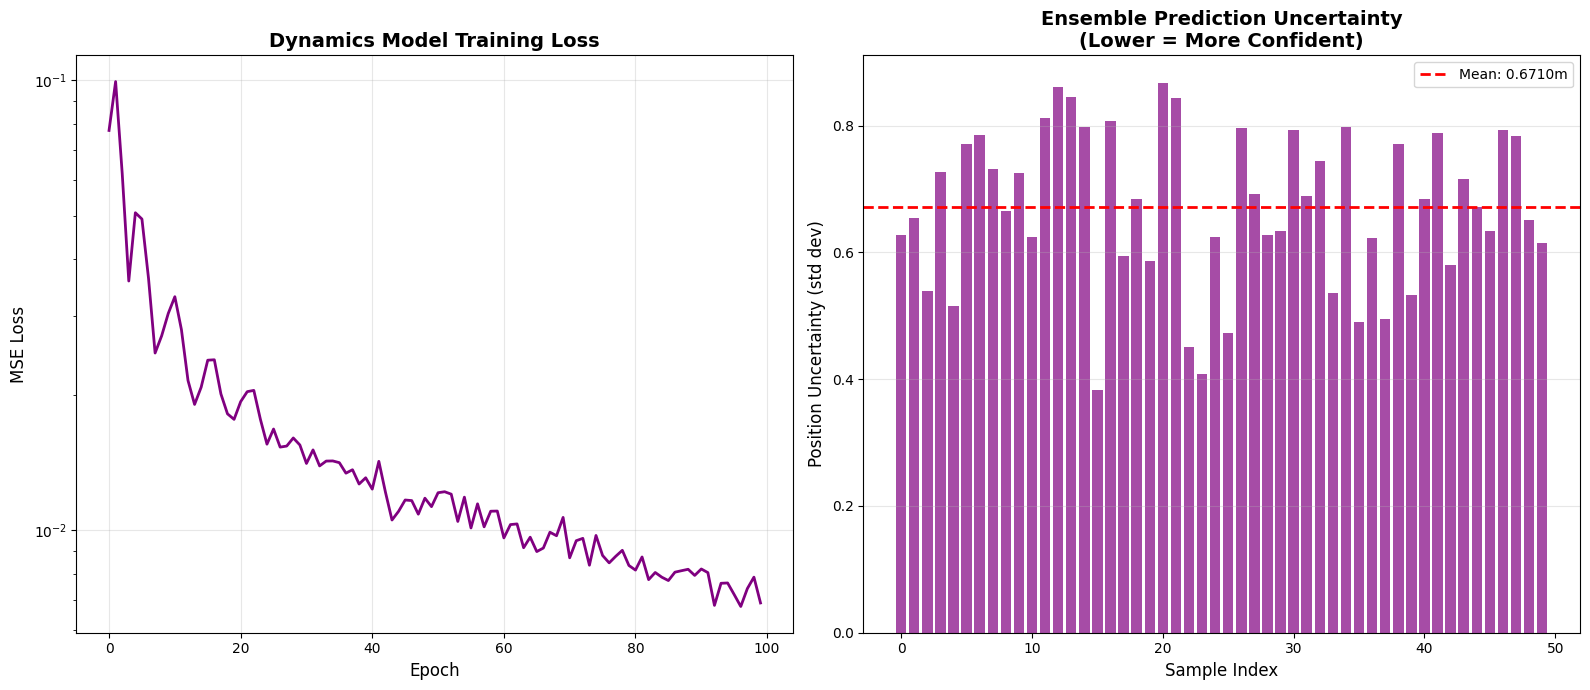


✅ Dynamics model test complete!


In [ ]:
# ============================================================================
# TEST 5: Dynamics Model - Learning Physics
# ============================================================================

print("=" * 70)
print("TEST 5: Dynamics Model (Learning Environment Physics)")
print("=" * 70)

# Create dynamics model
dynamics = EnsembleDynamics(num_models=3, state_dim=4, action_dim=2, 
                            hidden_dims=(128, 128), device='cpu')

print(f"\n⚙️  Ensemble Dynamics Architecture:")
print(f"  - Number of models: 3 (for uncertainty estimation)")
print(f"  - Input: state (4D) + action (2D) = 6D")
print(f"  - Hidden layers: (128, 128)")
print(f"  - Output: next_state (4D)")
print(f"  - Total parameters: {sum(p.numel() for p in dynamics.parameters()):,}")

# Create training data from transitions
states = torch.FloatTensor([t.state for t in transitions])
actions = torch.FloatTensor([t.action for t in transitions])
next_states = torch.FloatTensor([t.next_state for t in transitions])

print(f"\n📊 Training Data:")
print(f"  - Training samples: {len(states)}")

# Train dynamics model
print(f"\n🏋️  Training Dynamics Model...")

optimizer_dyn = torch.optim.Adam(dynamics.parameters(), lr=1e-3)

dyn_losses = []
for epoch in range(100):
    optimizer_dyn.zero_grad()
    
    # Predict next states
    pred_next = dynamics(states, actions)
    
    # MSE loss
    loss = torch.mean((pred_next - next_states) ** 2)
    loss.backward()
    optimizer_dyn.step()
    
    dyn_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"  Epoch {epoch}: MSE Loss = {loss.item():.6f}")

# Test prediction accuracy
print(f"\n📊 Prediction Accuracy Test:")
test_idx = 0
test_state = states[test_idx:test_idx+1]
test_action = actions[test_idx:test_idx+1]
true_next = next_states[test_idx:test_idx+1]

with torch.no_grad():
    pred_next = dynamics(test_state, test_action)
    
print(f"  Input State: {test_state[0].numpy()}")
print(f"  Action: {test_action[0].numpy()}")
print(f"  True Next State: {true_next[0].numpy()}")
print(f"  Predicted Next: {pred_next[0].numpy()}")
print(f"  Position Error: {torch.norm(pred_next[0, :2] - true_next[0, :2]).item():.6f}m")

# Visualize training and uncertainty
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Training loss
ax1.plot(dyn_losses, 'purple', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.set_title('Dynamics Model Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Prediction uncertainty (ensemble variance)
sample_states = states[:50]
sample_actions = actions[:50]

with torch.no_grad():
    all_predictions = dynamics.forward_all(sample_states, sample_actions)
    uncertainties = torch.std(all_predictions, dim=0).numpy()

# Show position uncertainty
pos_uncertainty = np.linalg.norm(uncertainties[:, :2], axis=1)

ax2.bar(range(len(pos_uncertainty)), pos_uncertainty, color='purple', alpha=0.7)
ax2.set_xlabel('Sample Index', fontsize=12)
ax2.set_ylabel('Position Uncertainty (std dev)', fontsize=12)
ax2.set_title('Ensemble Prediction Uncertainty\n(Lower = More Confident)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

mean_uncertainty = np.mean(pos_uncertainty)
ax2.axhline(mean_uncertainty, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_uncertainty:.4f}m')
ax2.legend()

plt.tight_layout()
plt.show()